# 위스콘신 유방암 데이터 분류

유방에서 만져지는 덩어리에 대한 세침 흡인 검사(FNA, 유방생검)를 통해 수집된 표본의 세포핵의 특성을 설명하는 데이터를 통해 암이 양성인지 악성인지 예측하기 위한 데이터 셋

> https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

> https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

## #01. 준비작업

### [1] 패키지 가져오기

In [10]:
import warnings
warnings.filterwarnings(action='ignore')

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

### [2] 데이터 가져오기

| 변수 | 설명 |
|---|---|
| id | 일련번호
| diagnosis | 유방조직의 진단 (`M`=악성, `B`=양성) |
| 그 밖의 변수 | 종양 세포에 관한 의학적 지표들 |

In [11]:
origin = my_read_excel("https://data.hossam.kr/mldata/breast-cancer-wisconsin.xlsx", index_col="id", categories=["diagnosis"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   diagnosis                569 non-null    category
 1   radius_mean              569 non-null    float64 
 2   texture_mean             569 non-null    float64 
 3   perimeter_mean           569 non-null    float64 
 4   area_mean                569 non-null    float64 
 5   smoothness_mean          569 non-null    float64 
 6   compactness_mean         569 non-null    float64 
 7   concavity_mean           569 non-null    float64 
 8   concave points_mean      569 non-null    float64 
 9   symmetry_mean            569 non-null    float64 
 10  fractal_dimension_mean   569 non-null    float64 
 11  radius_se                569 non-null    float64 
 12  texture_se               569 non-null    float64 
 13  perimeter_se             569 non-null    float64 
 14  are

## #02. 탐색적 데이터 분석

### [1] 상자그림

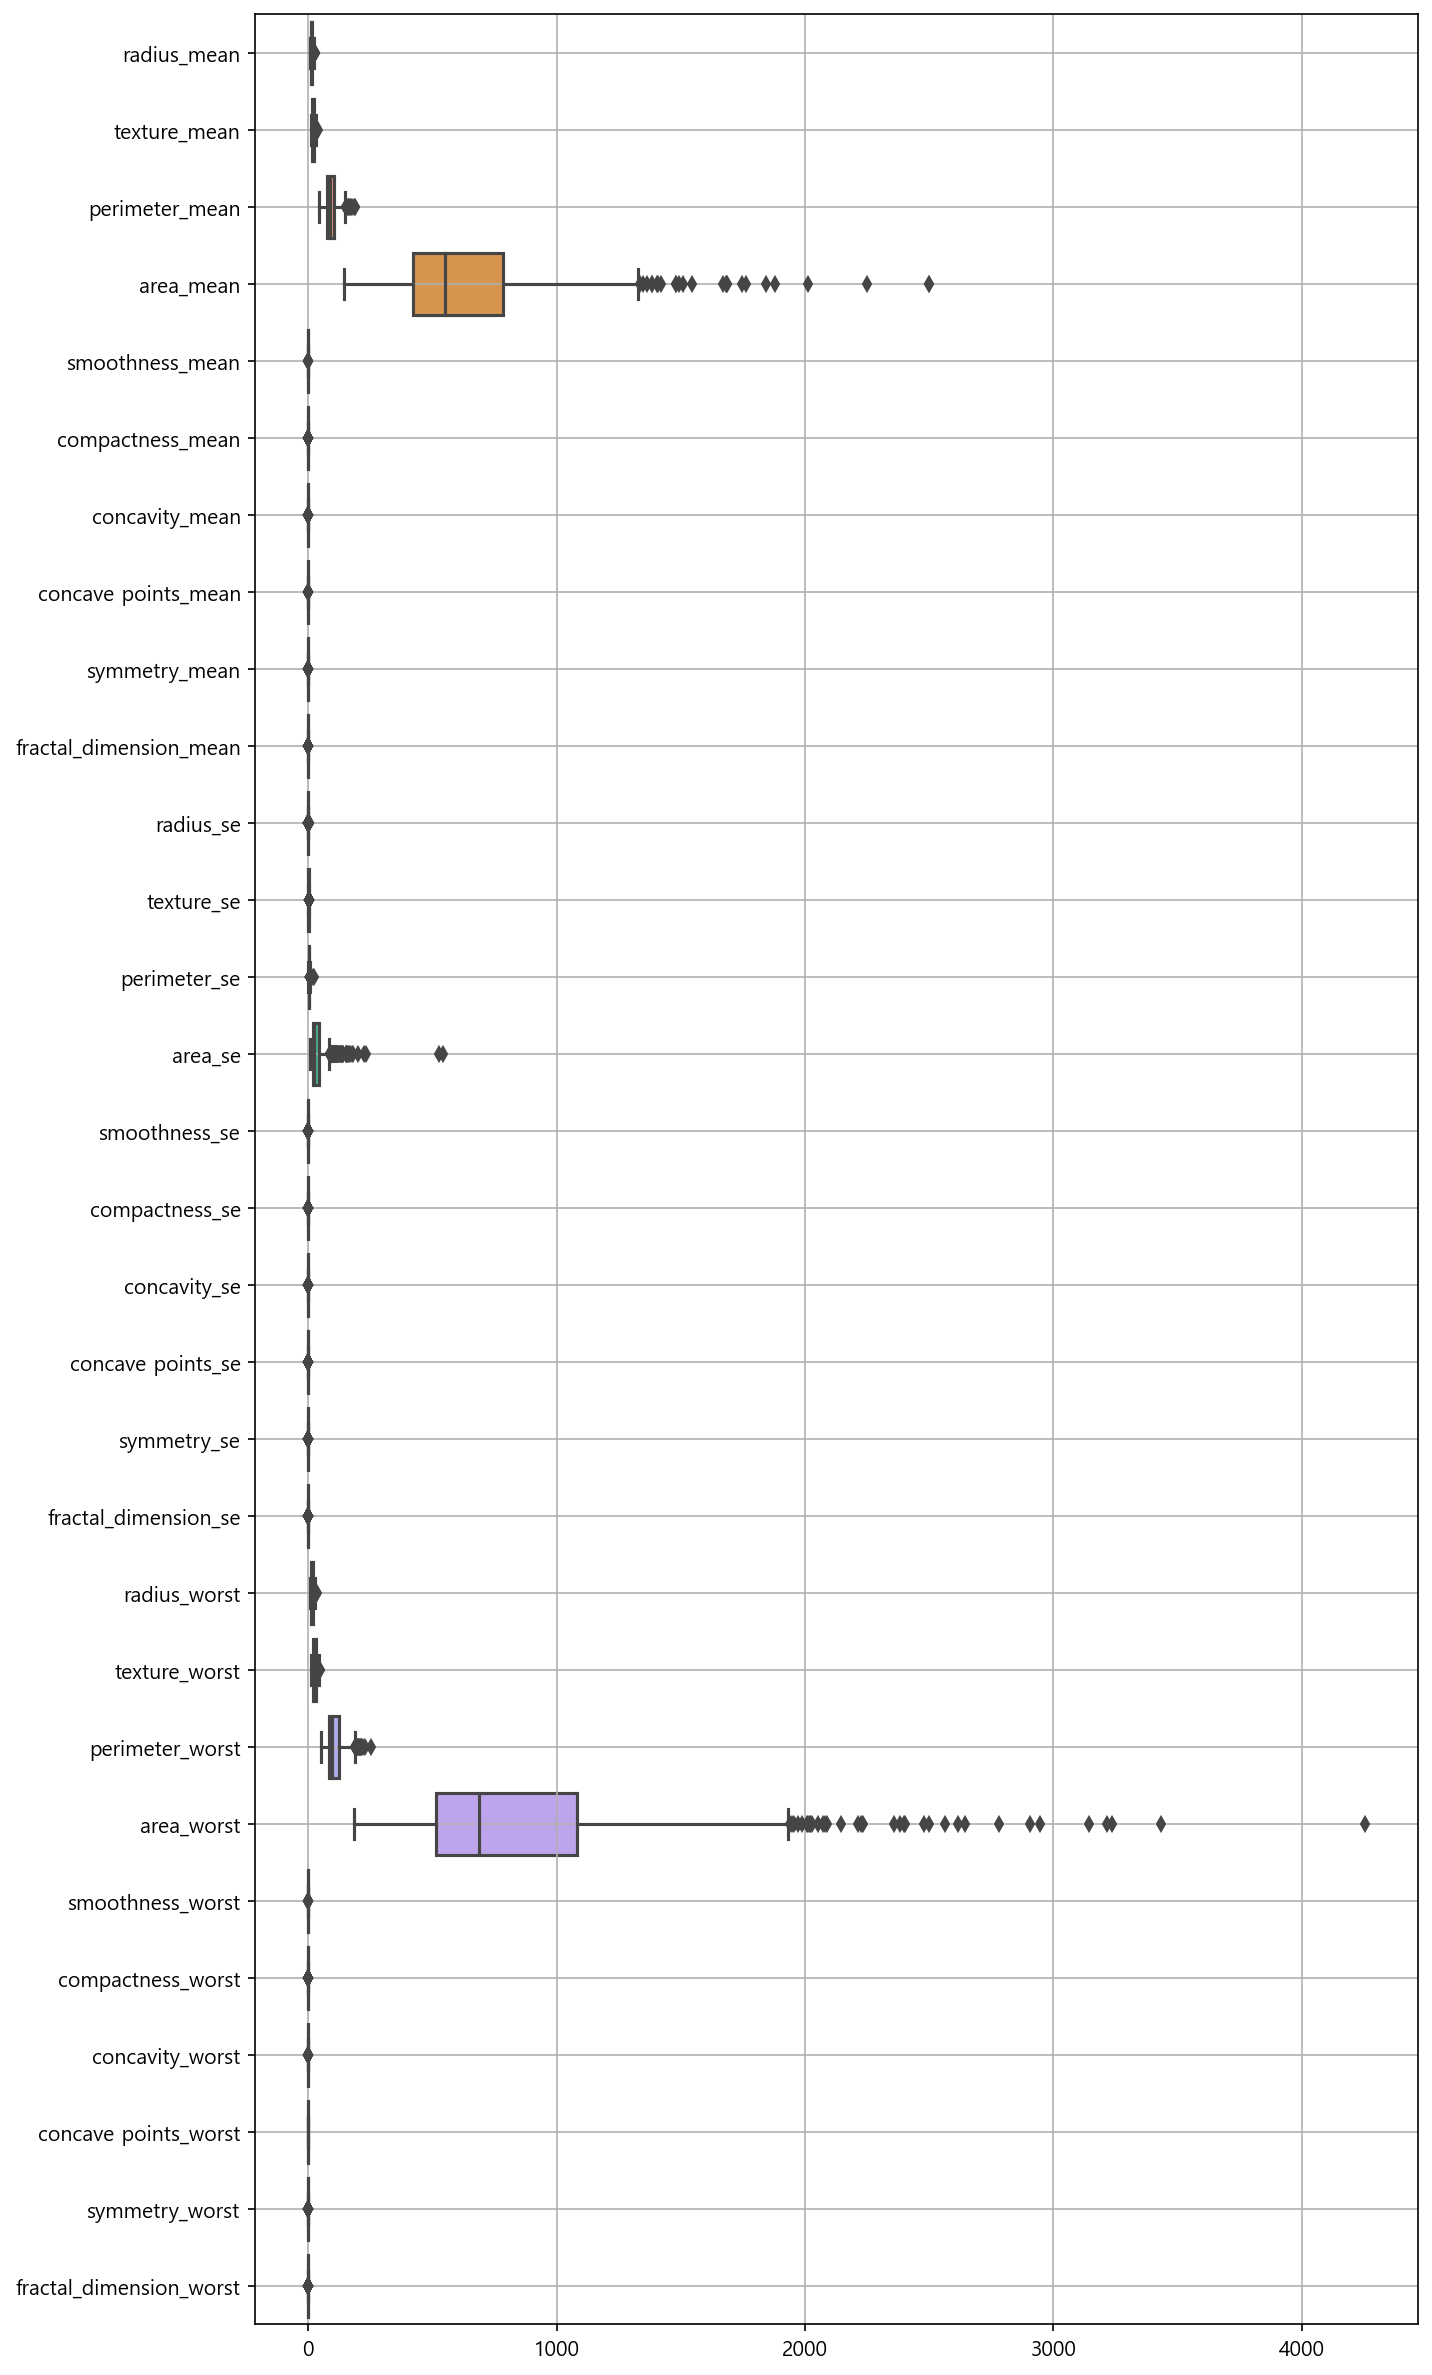

In [12]:
my_boxplot(origin, orient='h', figsize=(10, 20))

> 데이터 스케일링이 필요할 것으로 판단됨

### [2] 종속변수에 따른 데이터 분포 비교

In [13]:
yname = 'diagnosis'
xnames = list(origin.drop(yname, axis=1).columns)

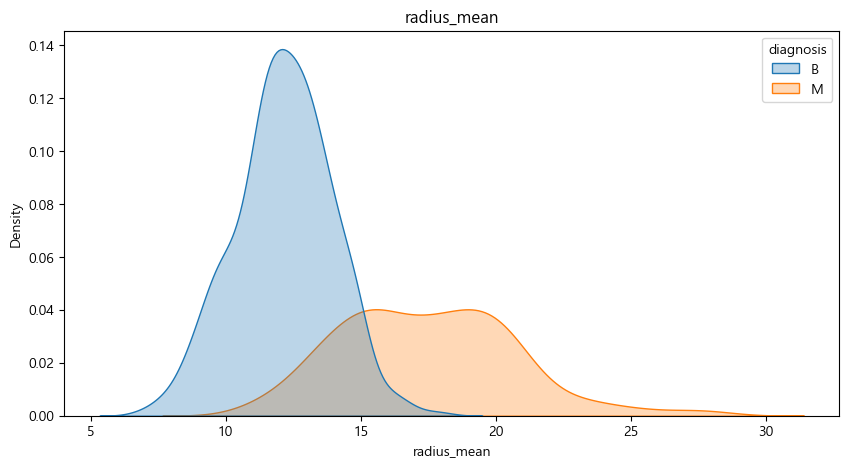

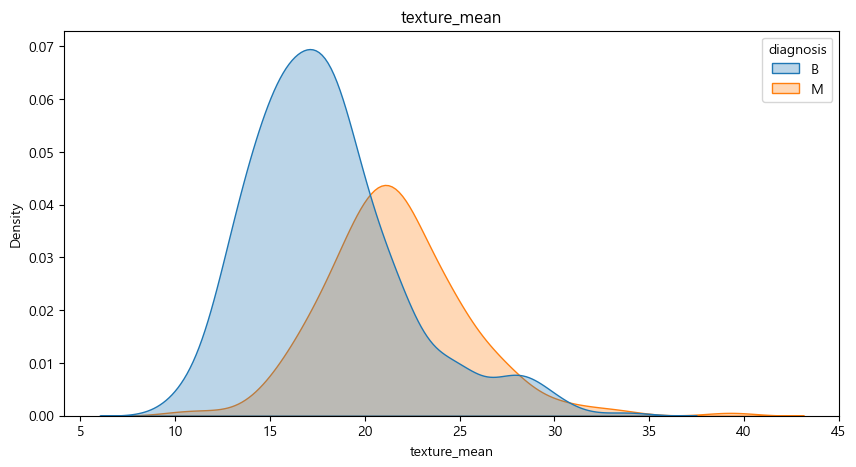

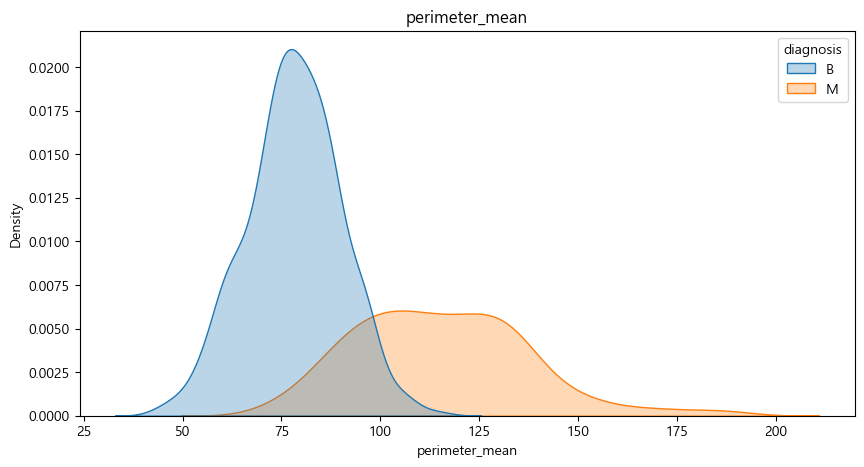

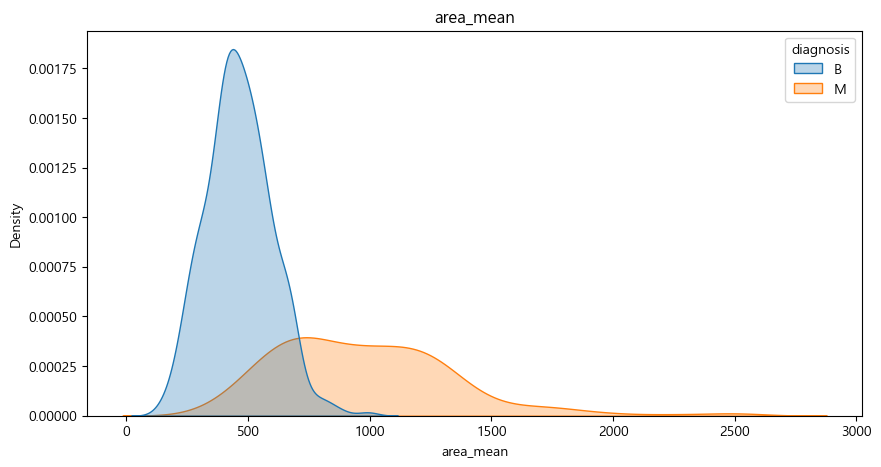

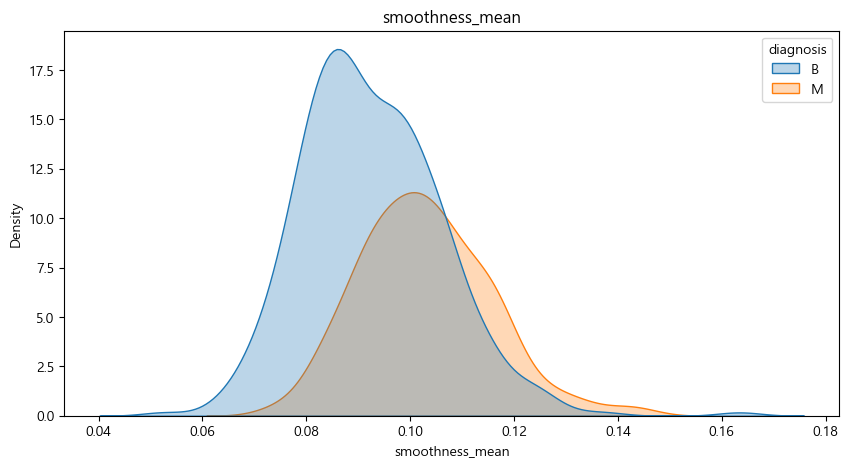

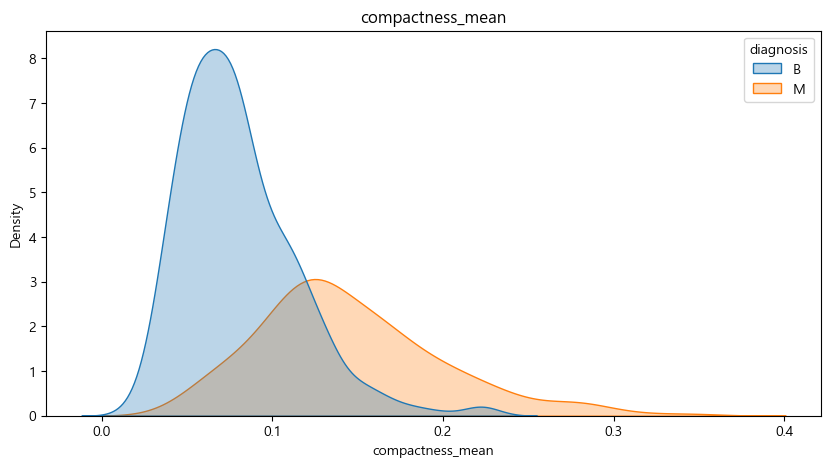

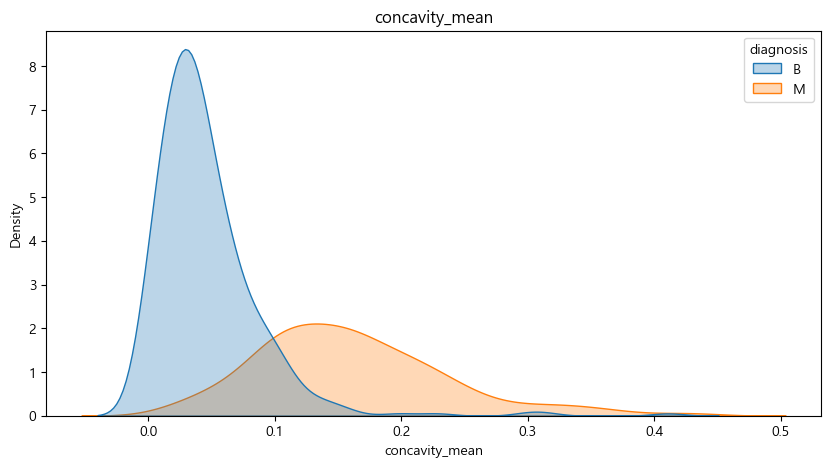

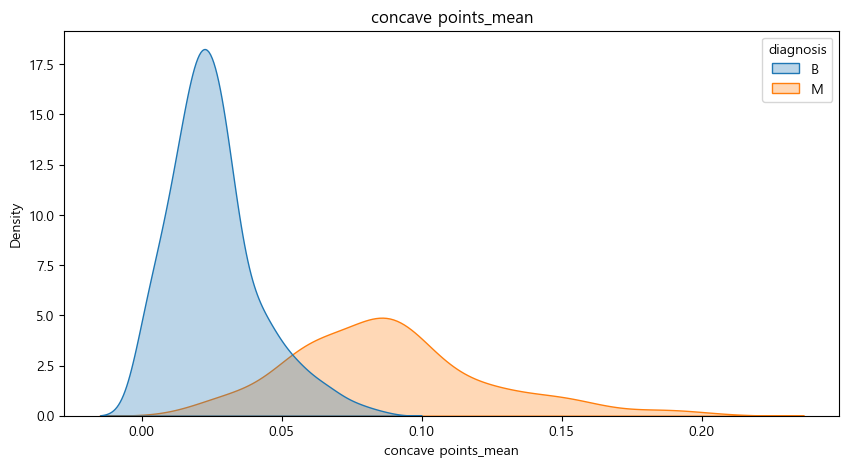

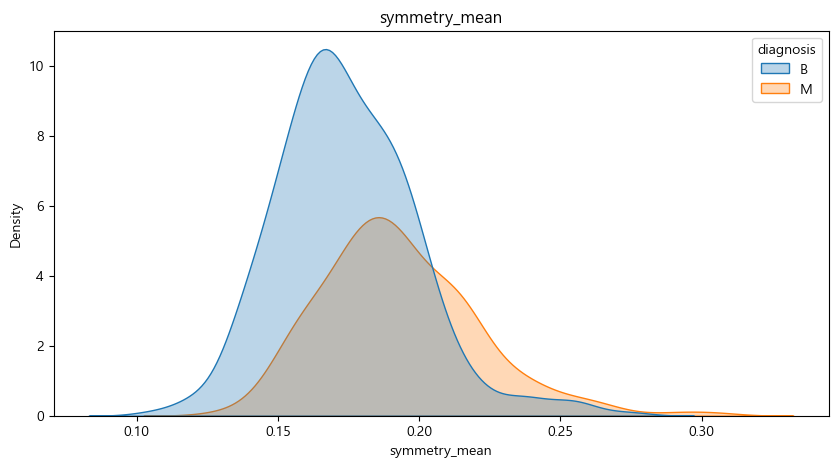

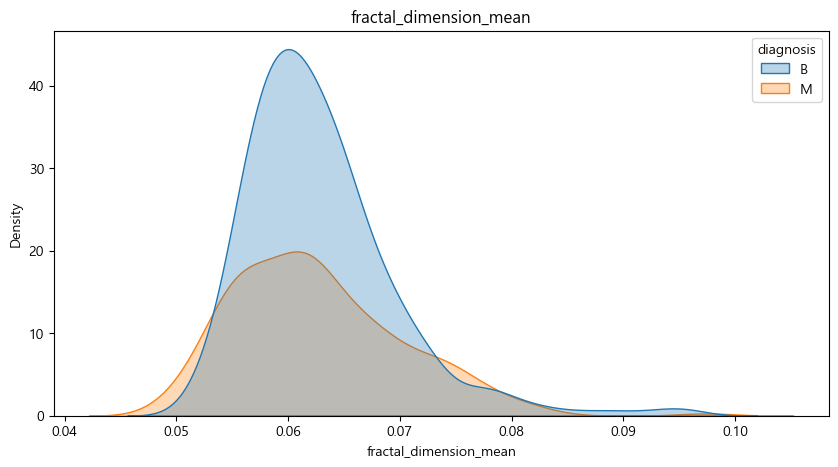

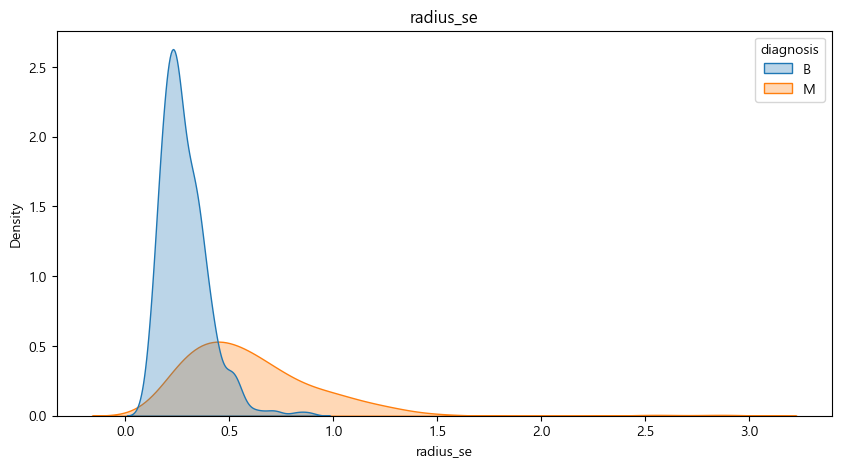

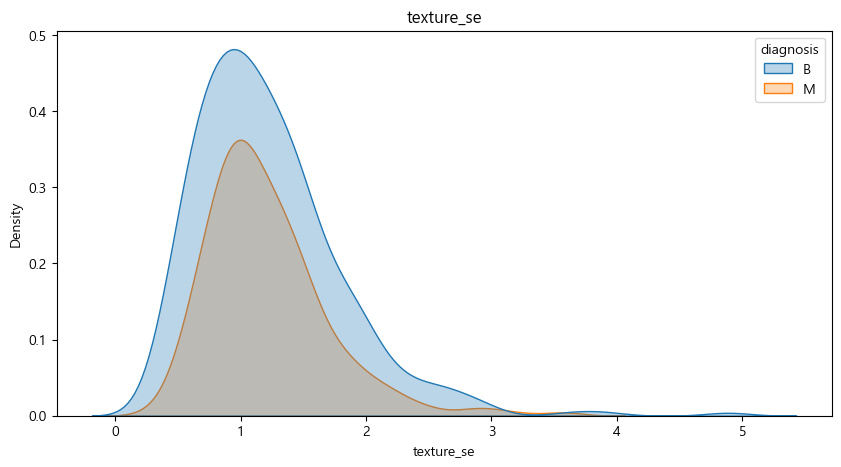

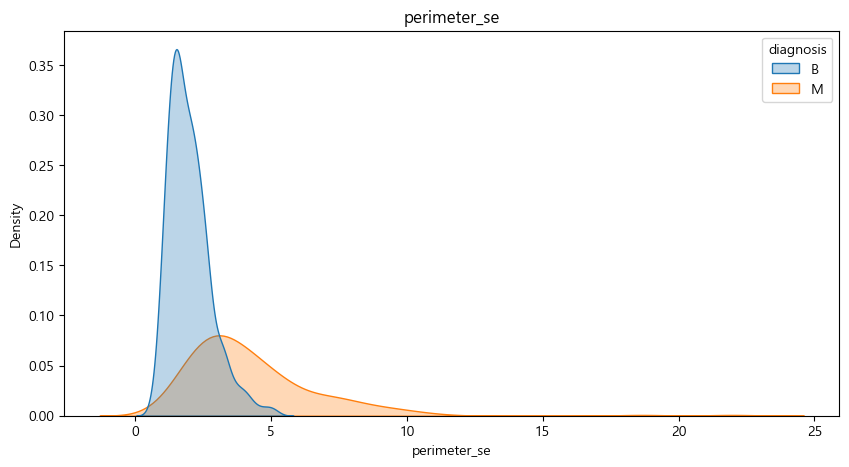

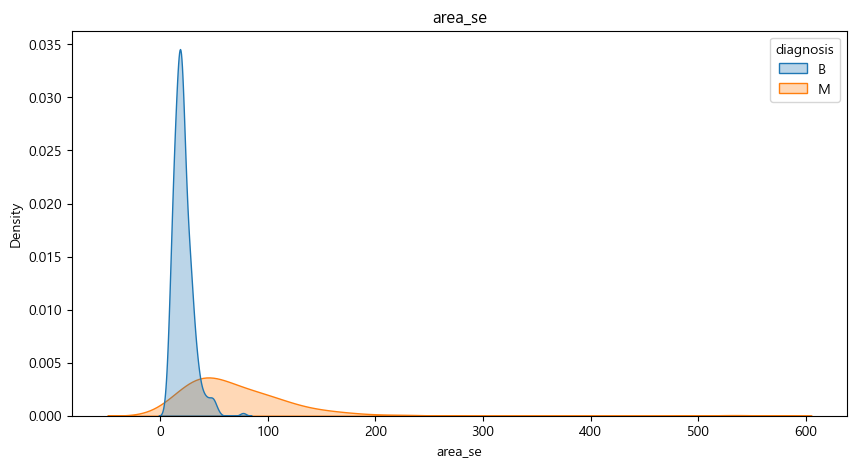

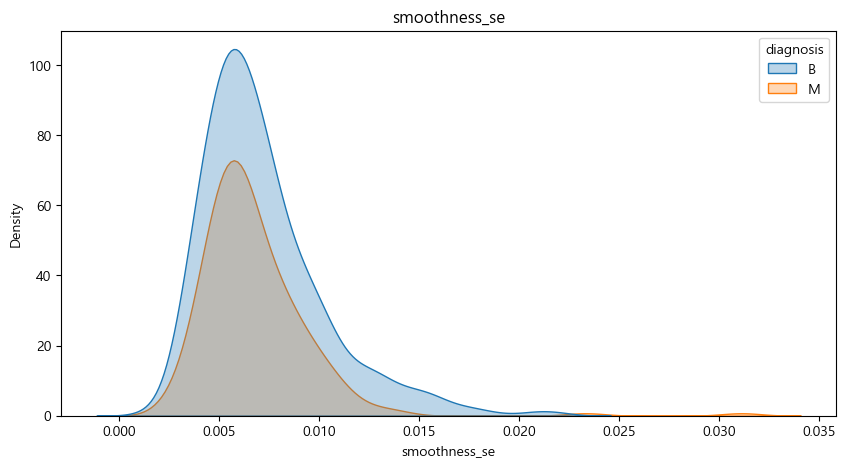

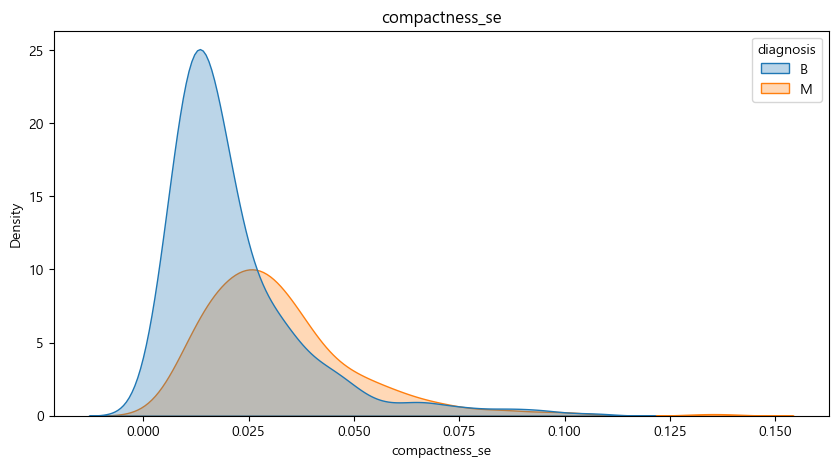

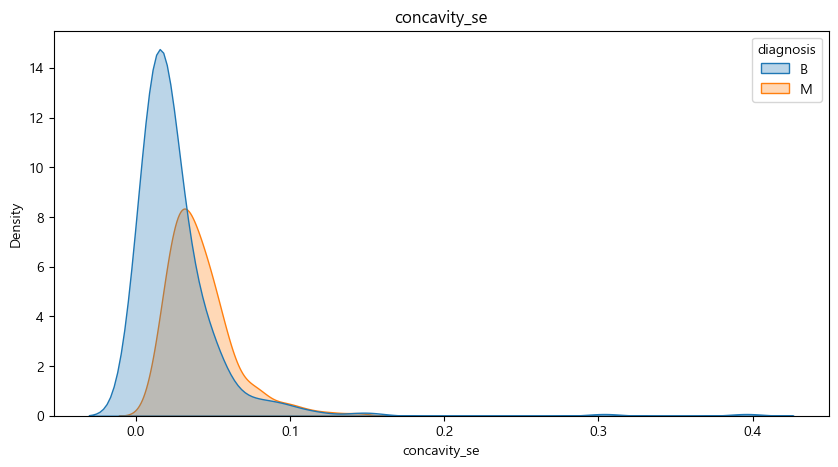

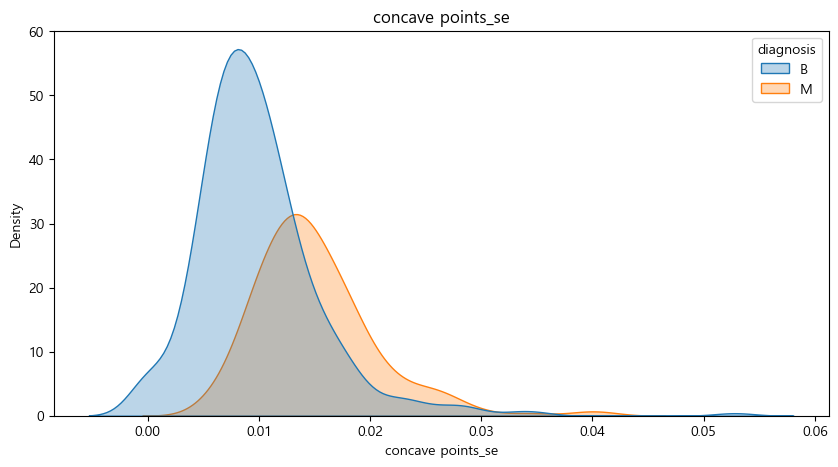

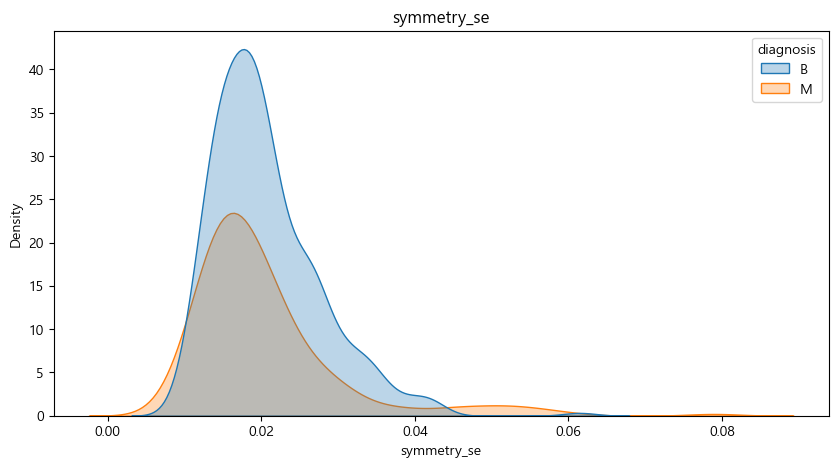

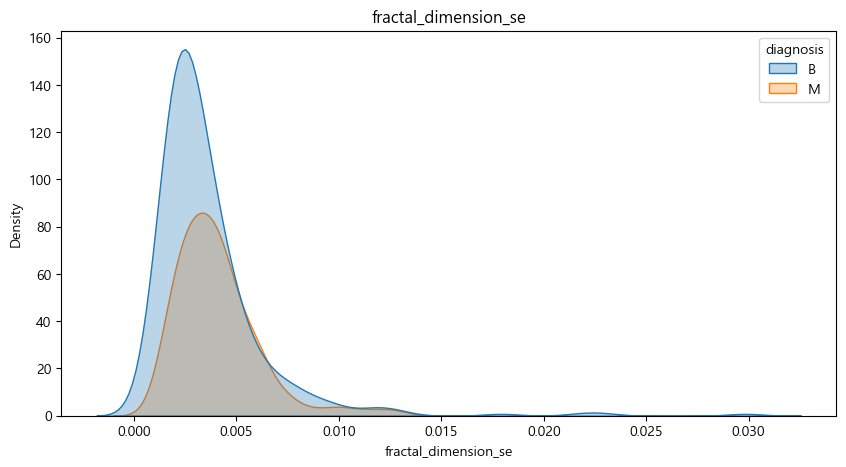

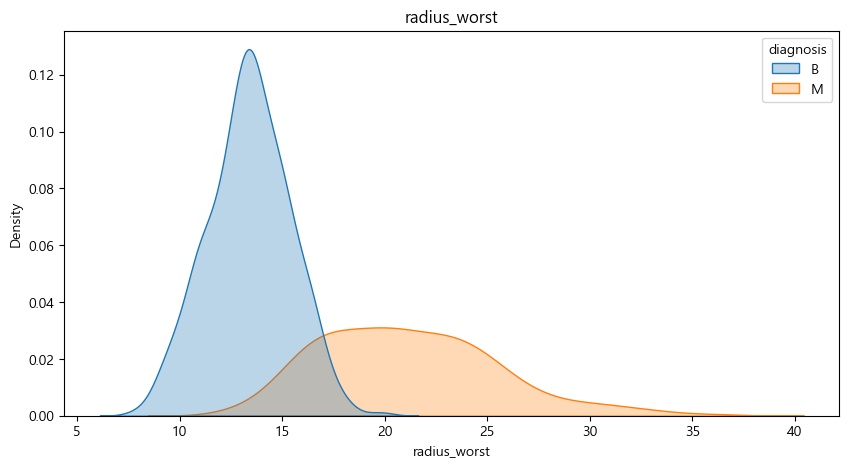

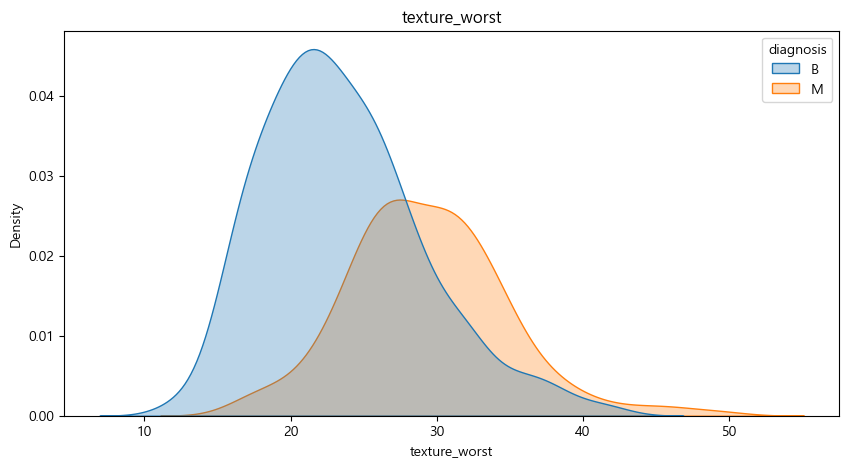

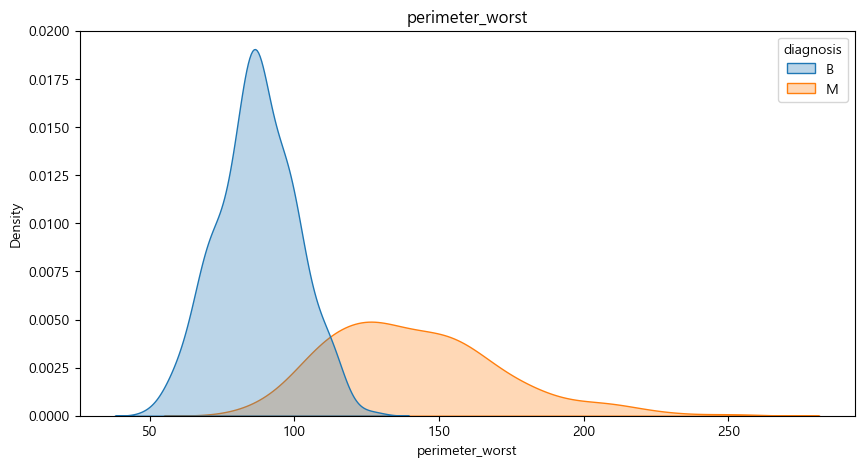

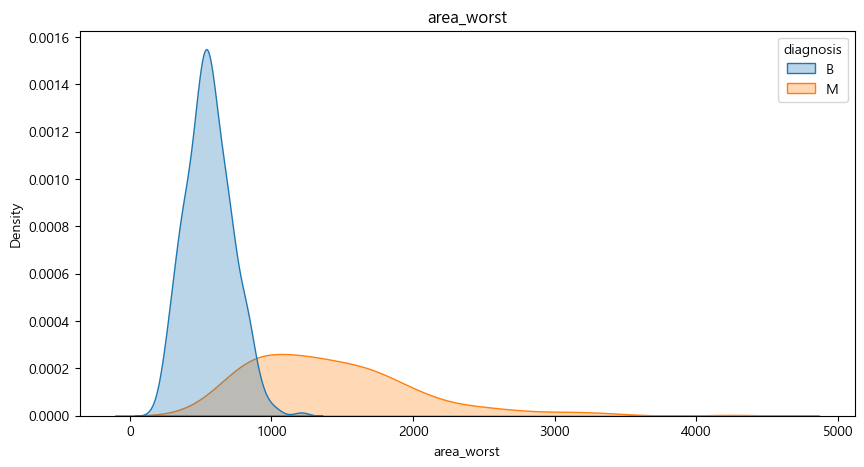

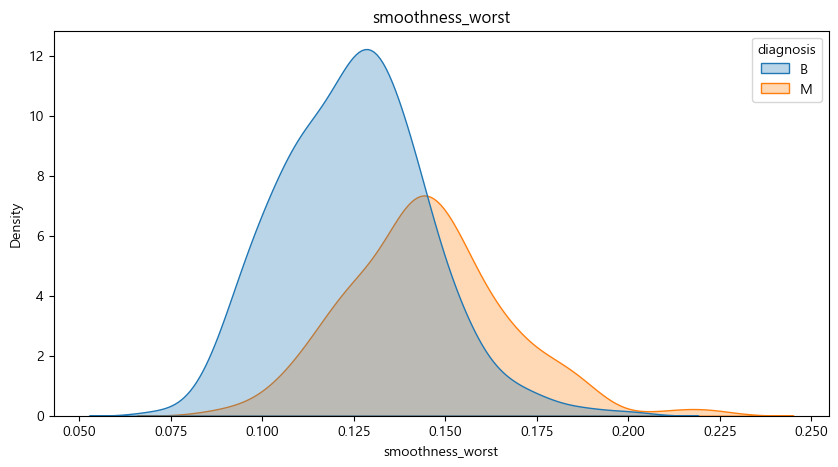

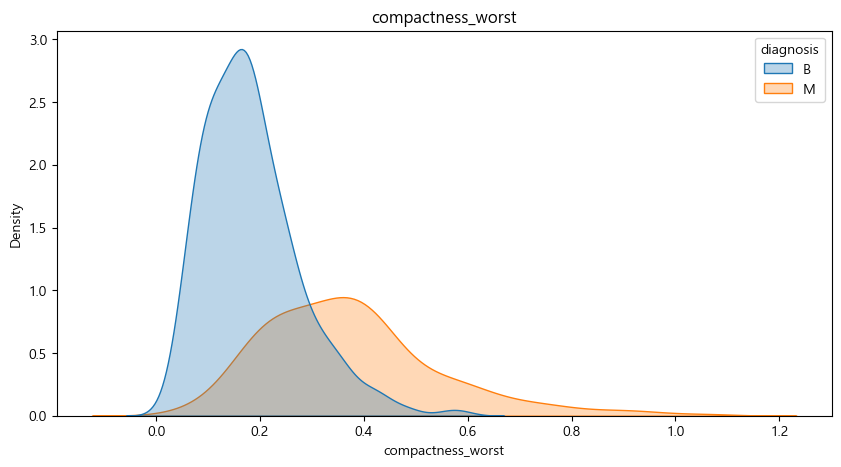

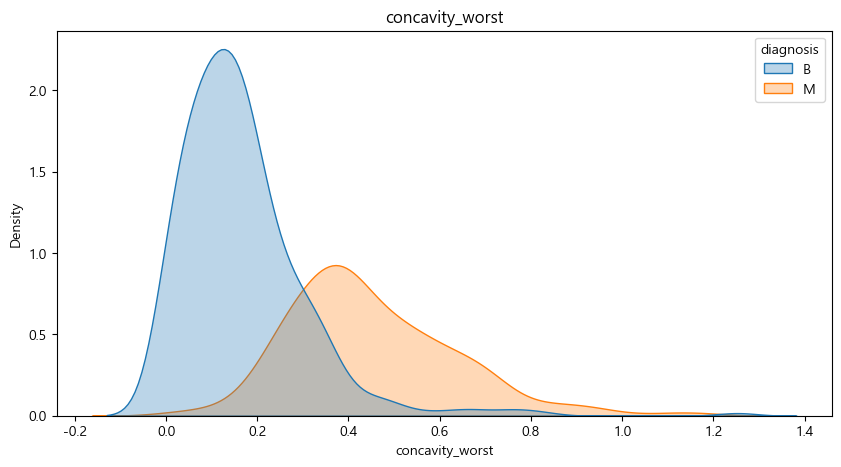

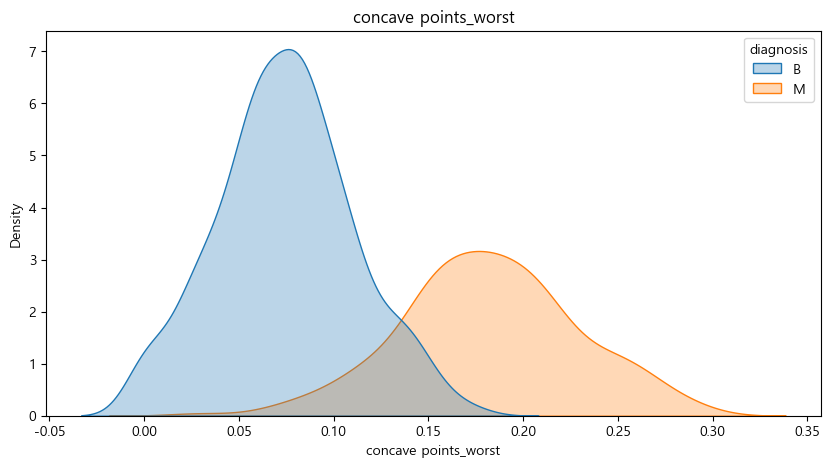

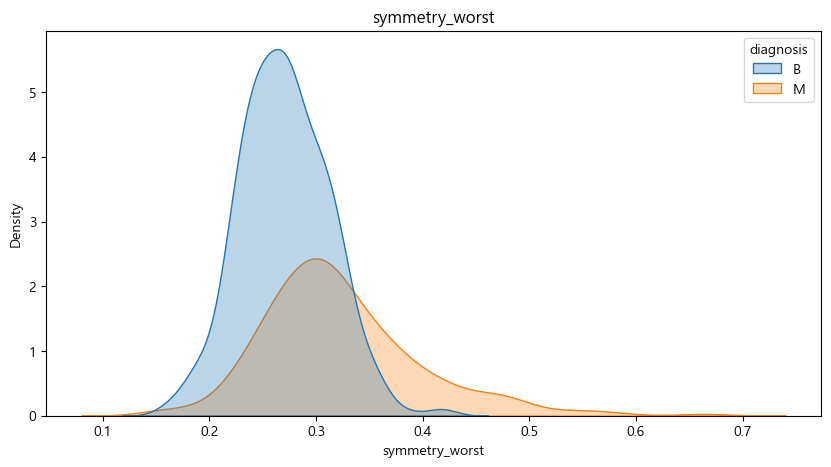

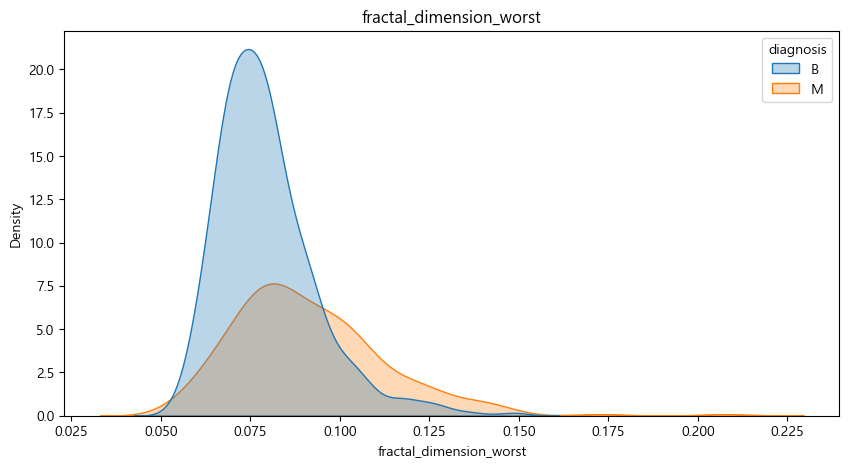

In [14]:
for x in xnames:
    if origin[x].dtype == 'category':
        my_stackplot(origin, xname=x, hue=yname, dpi=100, plt_title=x)
    else:
        my_kdeplot(origin, xname=x, hue=yname, fill=True, dpi=100, callback=lambda ax: ax.set_title(x))

> 일부 변수에서 악성,양성에 따른 평균이 유의미한 차이가 없는 것으로 보이기는 하지만 일단 모든 변수를 다 투입하여 분석을 시도

## #03. 데이터 전처리

### [1] 스케일링

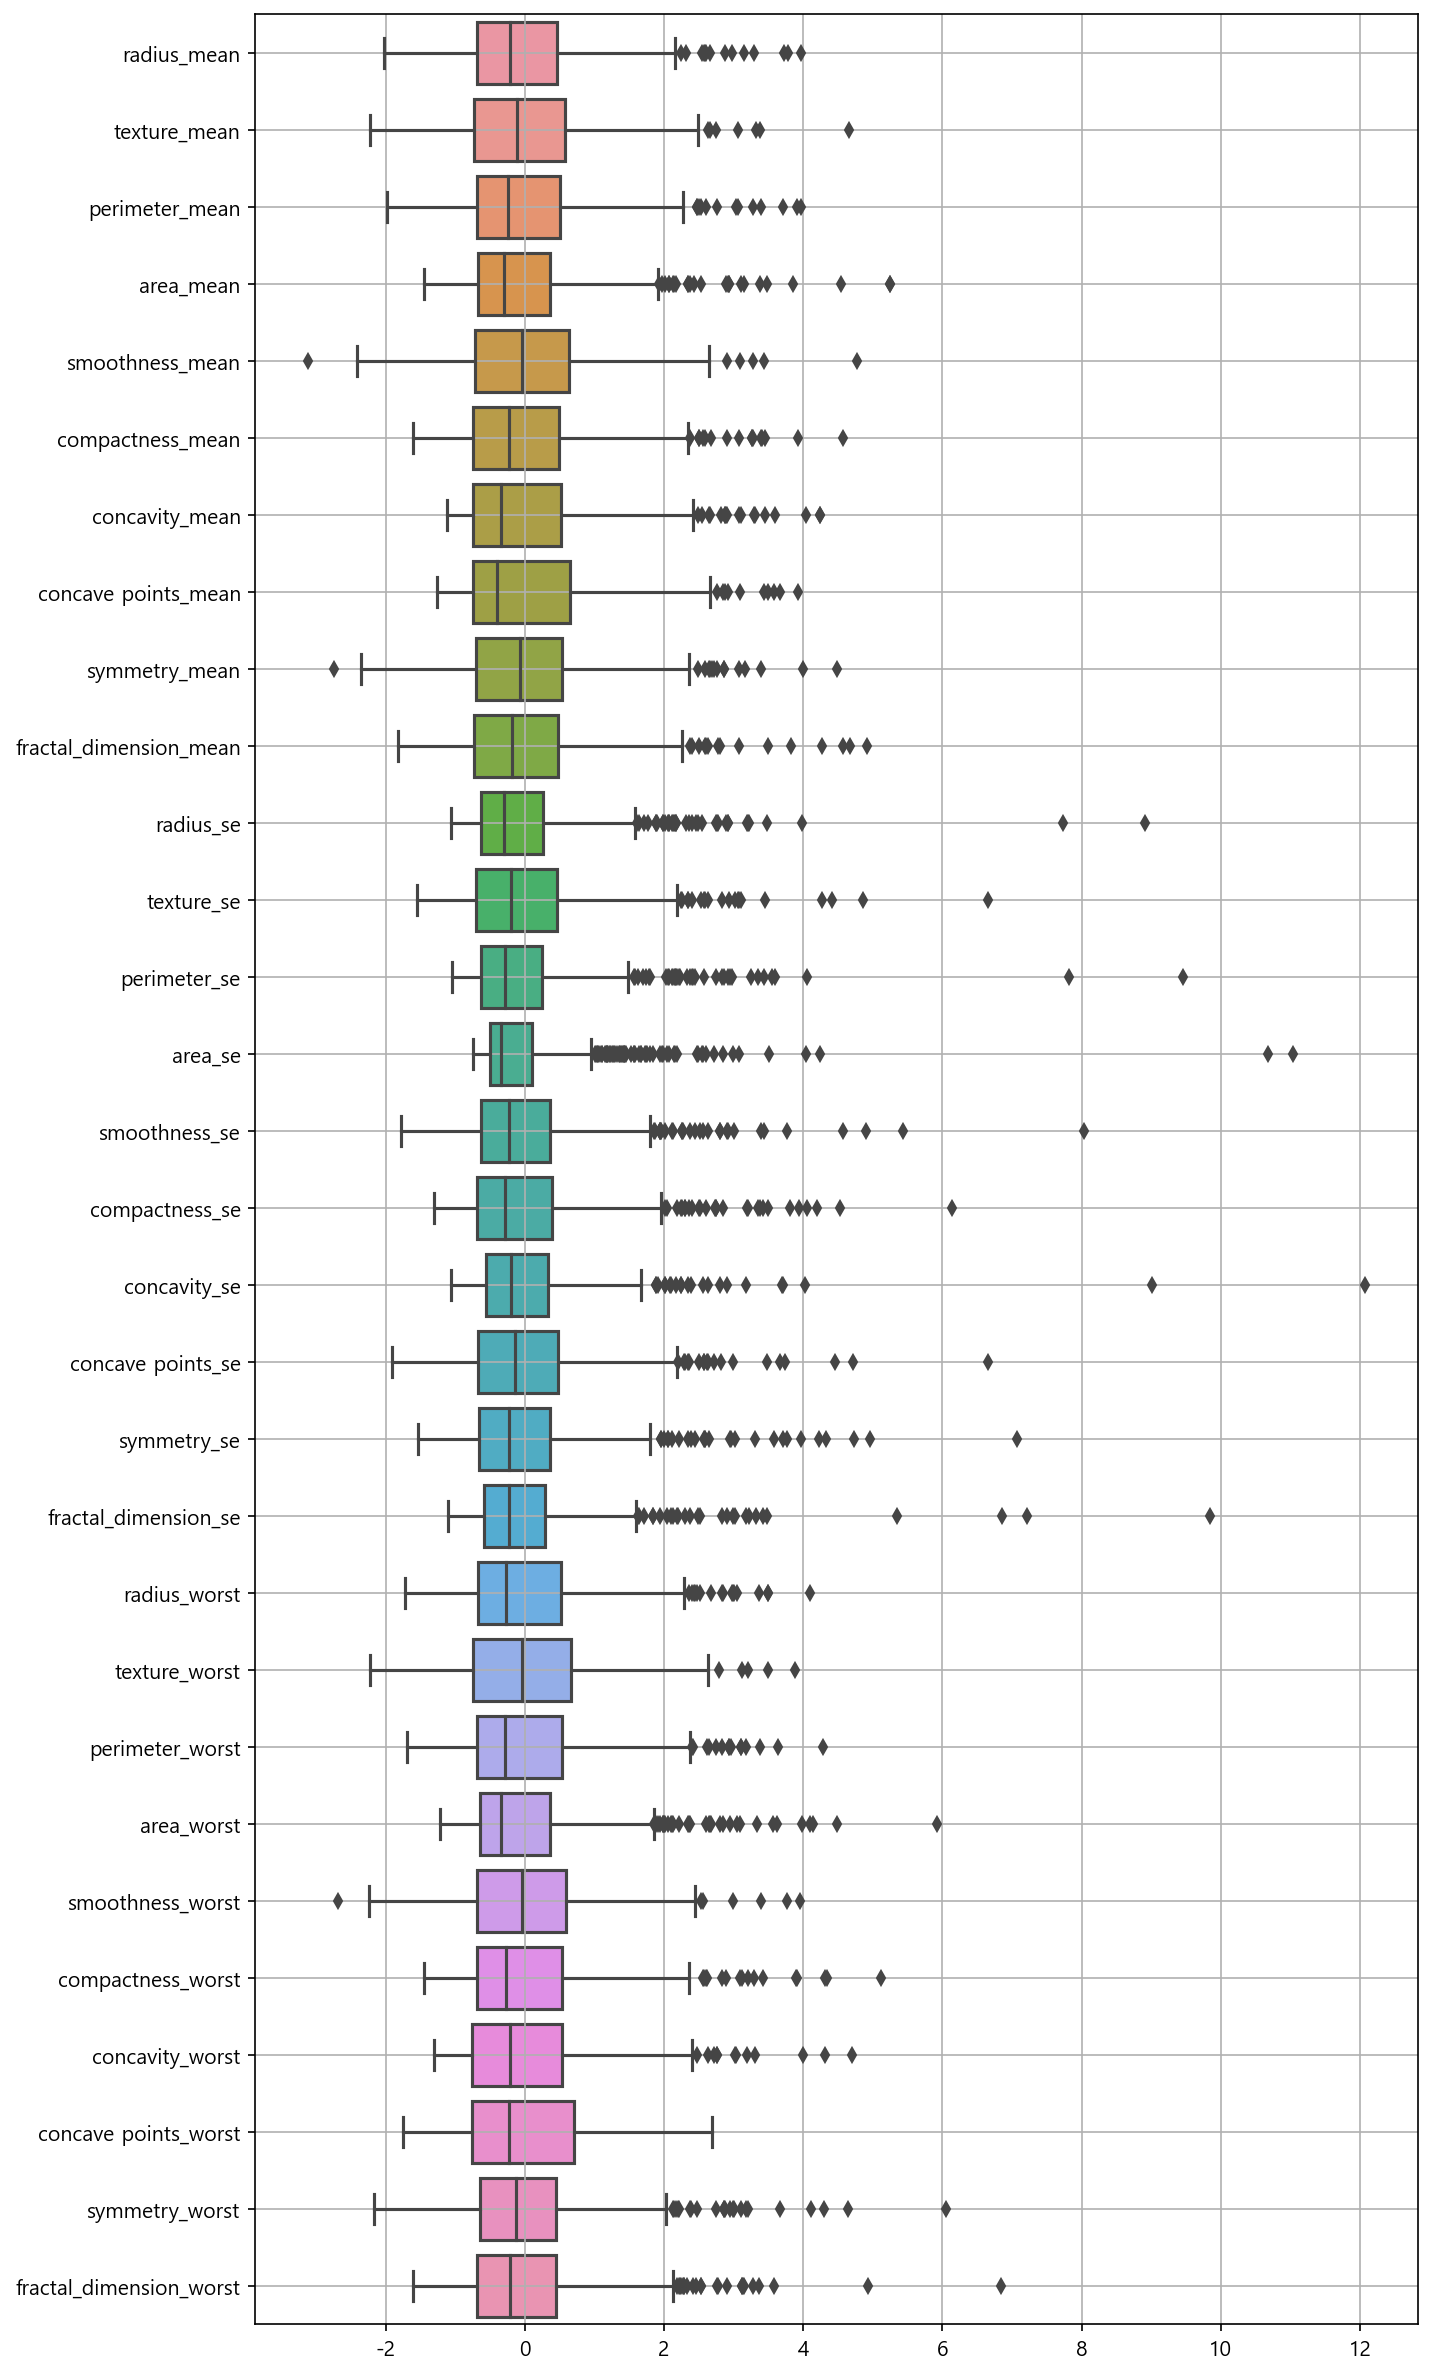

In [15]:
df = my_standard_scaler(origin, 'diagnosis')
my_boxplot(df, orient='h', figsize=(10, 20))



### [2] 종속변수 라벨링

`M`=악성=`1`, `B`=양성=`0`

In [16]:
df2 = my_labelling(df, 'diagnosis')
my_pretty_table(df2.head())

+----------+---------------+----------------+------------------+-------------+-------------------+--------------------+------------------+-----------------------+-----------------+--------------------------+-------------+--------------+----------------+-----------+-----------------+------------------+----------------+---------------------+---------------+------------------------+----------------+-----------------+-------------------+--------------+--------------------+---------------------+-------------------+------------------------+------------------+---------------------------+-------------+
|       id |   radius_mean |   texture_mean |   perimeter_mean |   area_mean |   smoothness_mean |   compactness_mean |   concavity_mean |   concave points_mean |   symmetry_mean |   fractal_dimension_mean |   radius_se |   texture_se |   perimeter_se |   area_se |   smoothness_se |   compactness_se |   concavity_se |   concave points_se |   symmetry_se |   fractal_dimension_se |   radius_worst 

## #04. 모든 데이터를 활용한 기본 분석 모형 구현

### [1] 데이터 분할

In [17]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'diagnosis')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

### [2] 로지스틱 회귀

[교차검증]
+----+-------+------------+-----------+-------------------+
|    |     C |   max_iter | penalty   |   mean_test_score |
|----+-------+------------+-----------+-------------------|
|  7 |   0.1 |        500 | l2        |           0.96731 |
| 10 |     1 |        500 | l2        |           0.96481 |
| 13 |    10 |        500 | l2        |          0.962247 |
| 16 |   100 |        500 | l2        |          0.962247 |
|  4 |  0.01 |        500 | l2        |          0.942152 |
|  1 | 0.001 |        500 | l2        |          0.869335 |
+----+-------+------------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.859152 |  

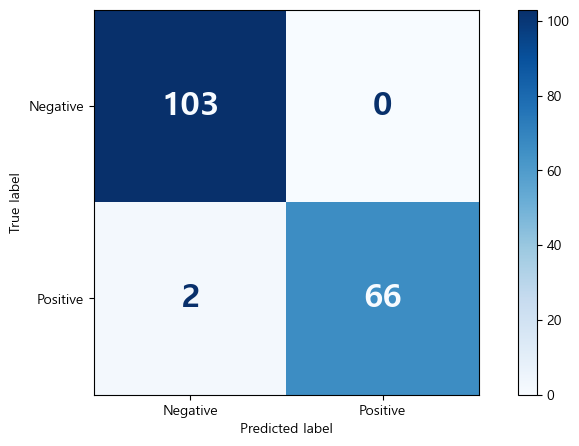


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


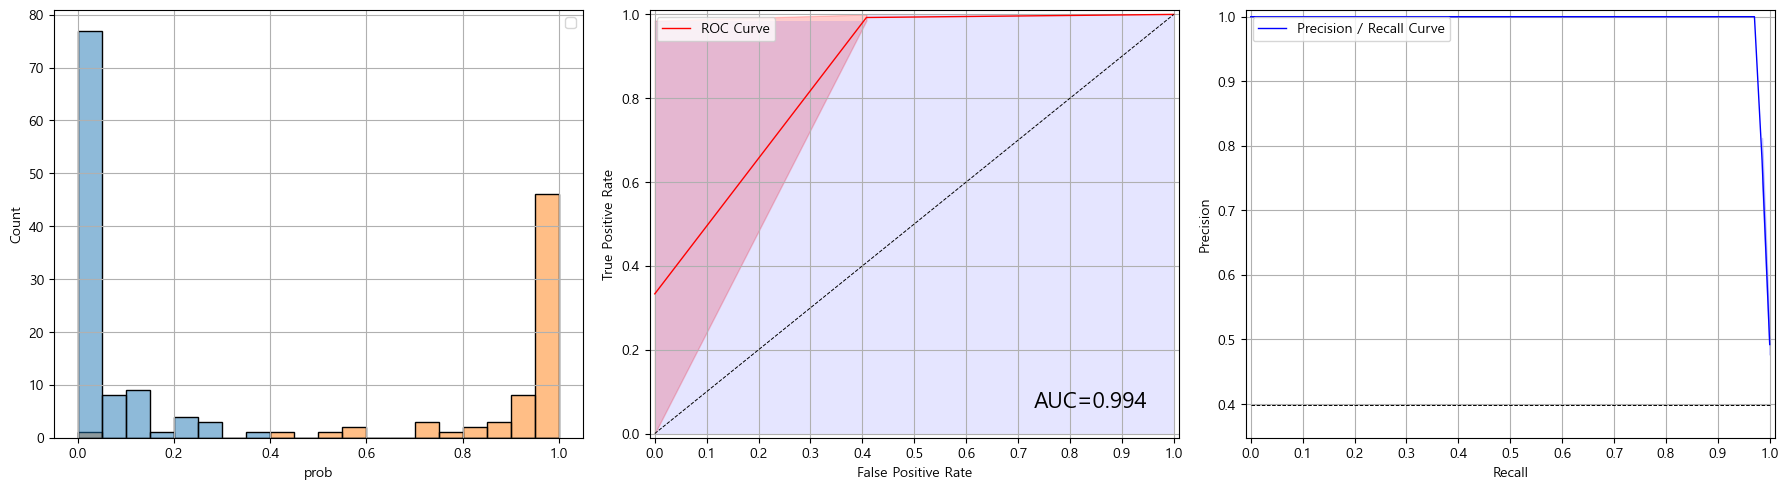


[학습곡선]


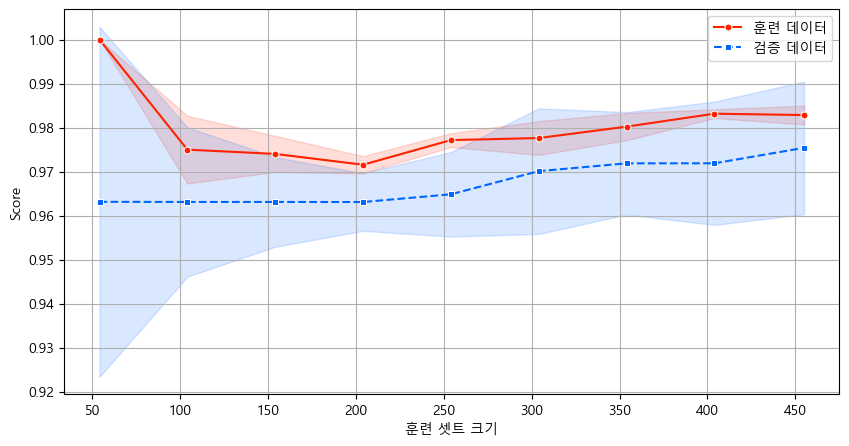

+----+------------+-------------------------+--------------------+------------+---------+------------+---------+------------+
|    | 종속변수   | 독립변수                |   B(비표준화 계수) |   표준오차 |       t |   유의확률 |     VIF |   OddsRate |
|----+------------+-------------------------+--------------------+------------+---------+------------+---------+------------|
|  2 | diagnosis  | perimeter_mean          |             0.3754 |     36.122 |  0.0104 |      0.992 | 5955.95 |     1.4556 |
|  0 | diagnosis  | radius_mean             |             0.3883 |     36.285 |  0.0107 |      0.991 | 5607.26 |     1.4744 |
| 20 | diagnosis  | radius_worst            |             0.4869 |     18.834 |  0.0259 |      0.979 | 927.261 |     1.6272 |
| 22 | diagnosis  | perimeter_worst         |             0.4462 |     11.835 |  0.0377 |       0.97 | 686.316 |     1.5624 |
|  3 | diagnosis  | area_mean               |             0.3672 |      19.91 |  0.0184 |      0.985 | 569.501 |     1.4437 |
| 23 | diagnos

LogisticRegression(C=0.1, max_iter=500, n_jobs=-1)

In [18]:
my_logistic_classification(x_train, y_train, x_test, y_test)

## #05. 성능 개선 시도

### [1] 다중 공선성 제거

[교차검증]
+----+-------+------------+-----------+-------------------+
|    |     C |   max_iter | penalty   |   mean_test_score |
|----+-------+------------+-----------+-------------------|
| 13 |    10 |        500 | l2        |          0.962184 |
| 10 |     1 |        500 | l2        |          0.957184 |
| 16 |   100 |        500 | l2        |          0.954684 |
|  7 |   0.1 |        500 | l2        |          0.952215 |
|  4 |  0.01 |        500 | l2        |          0.901899 |
|  1 | 0.001 |        500 | l2        |          0.690949 |
+----+-------+------------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.901051 |  

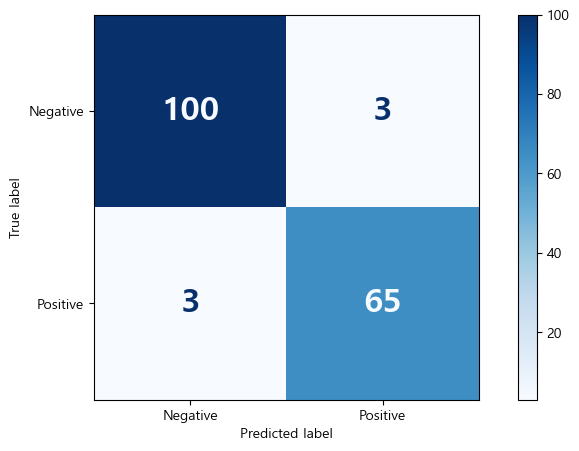


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


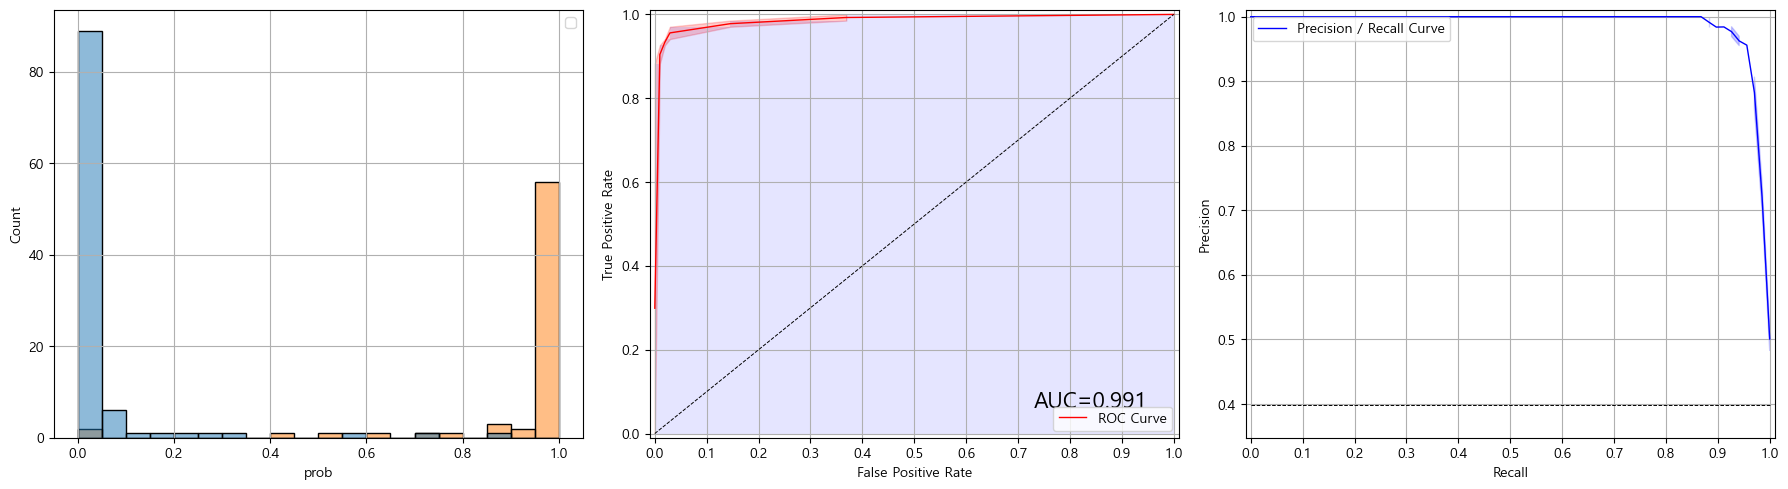


[학습곡선]


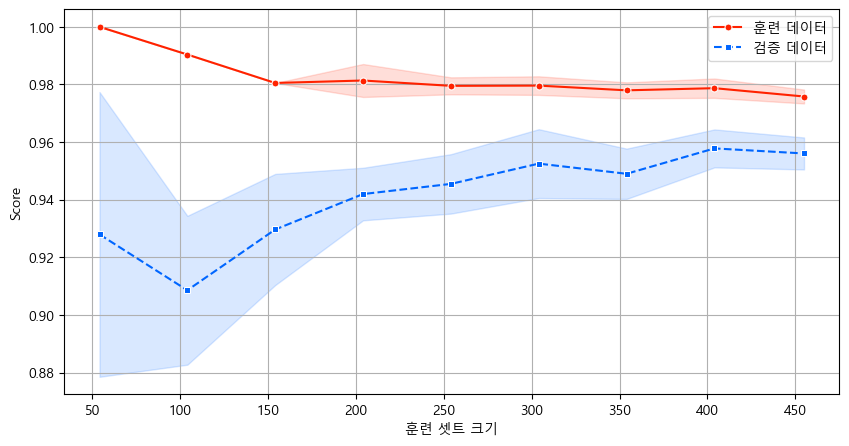

+----+------------+------------------------+--------------------+------------+---------+------------+---------+------------+
|    | 종속변수   | 독립변수               |   B(비표준화 계수) |   표준오차 |       t |   유의확률 |     VIF |   OddsRate |
|----+------------+------------------------+--------------------+------------+---------+------------+---------+------------|
|  2 | diagnosis  | compactness_mean       |             1.0615 |      3.096 |  0.3429 |      0.732 | 9.34434 |     2.8906 |
|  4 | diagnosis  | fractal_dimension_mean |             0.1705 |      2.981 |  0.0572 |      0.954 | 6.56224 |     1.1859 |
|  8 | diagnosis  | concavity_se           |             0.7037 |      1.815 |  0.3877 |      0.698 | 5.85417 |     2.0212 |
| 12 | diagnosis  | area_worst             |             7.3162 |      3.703 |  1.9759 |      0.048 | 5.40988 |    1504.48 |
| 11 | diagnosis  | fractal_dimension_se   |             -2.812 |      2.061 | -1.3645 |      0.172 | 5.13809 |     0.0601 |
|  6 | diagnosis  | pe

LogisticRegression(C=10, max_iter=500, n_jobs=-1)

In [19]:
ignore = ['perimeter_mean', 'perimeter_worst', 'radius_mean', 'radius_worst', 'radius_se', 'concavity_mean', 'compactness_worst', 'concave points_worst', 'area_se', 'concave points_mean', 'concavity_worst', 'area_mean', 'compactness_se', 'smoothness_worst', 'texture_worst', 'fractal_dimension_worst']
x_tr = x_train.drop(ignore, axis=1)
x_te = x_test.drop(ignore, axis=1)
my_logistic_classification(x_tr, y_train, x_te, y_test)

> 성능에 큰 차이를 보이지 않는다.
>
> 오히려 정확도는 2% 떨어졌다.
>
> 재현률도 95%에서 90%로 떨어졌다.

### [2] 데이터 불균형 해소

#### (1) RandomUnderSampler

In [20]:
undersampler = RandomUnderSampler(sampling_strategy="majority", random_state=777)
x_under, y_under = undersampler.fit_resample(x_train, y_train)
y_under.value_counts()

0    144
1    144
Name: diagnosis, dtype: int64

[교차검증]
+----+-------+------------+-----------+-------------------+
|    |     C |   max_iter | penalty   |   mean_test_score |
|----+-------+------------+-----------+-------------------|
| 10 |     1 |        500 | l2        |          0.968663 |
|  4 |  0.01 |        500 | l2        |          0.961827 |
|  7 |   0.1 |        500 | l2        |          0.961766 |
| 13 |    10 |        500 | l2        |          0.958258 |
| 16 |   100 |        500 | l2        |          0.947852 |
|  1 | 0.001 |        500 | l2        |          0.913128 |
+----+-------+------------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.922132 |  

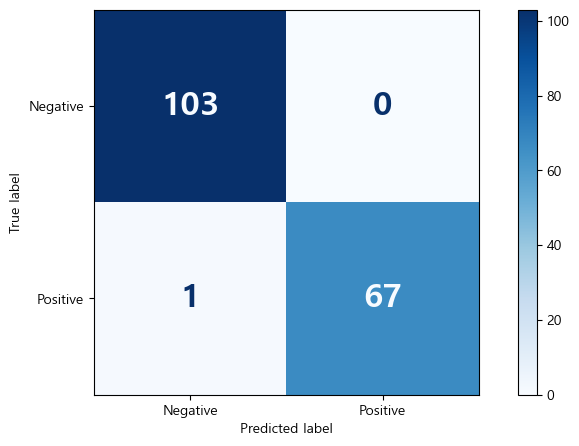


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


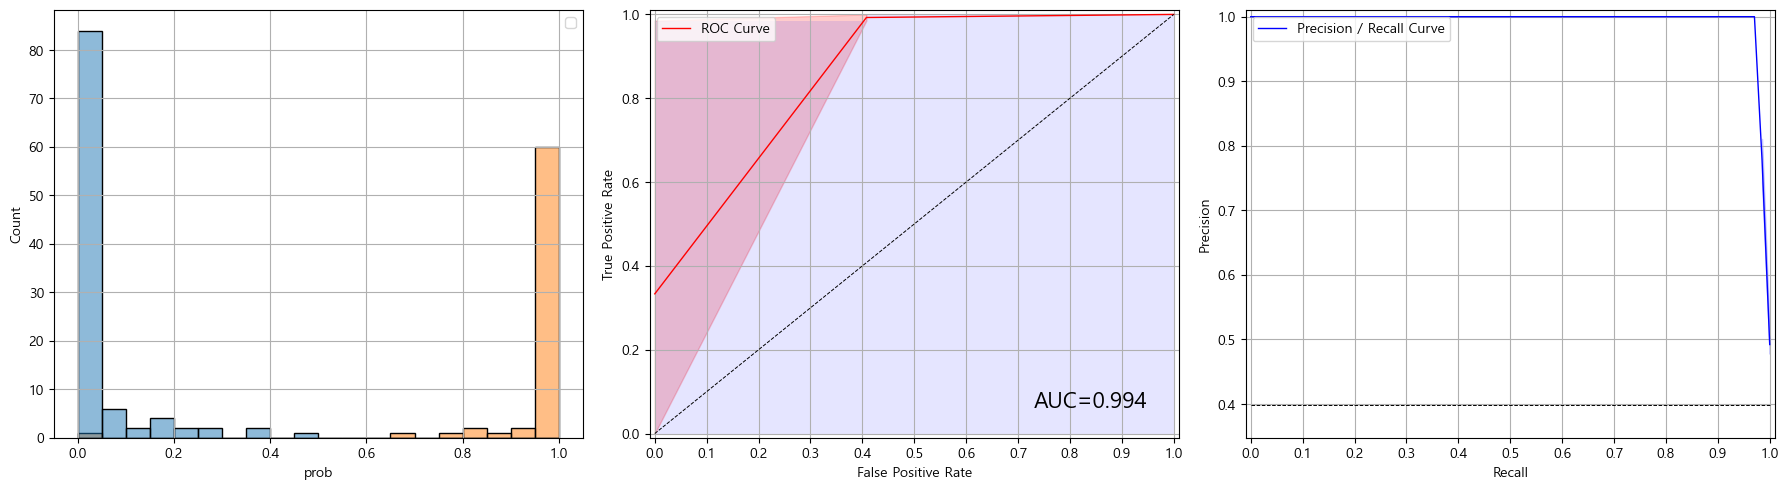


[학습곡선]


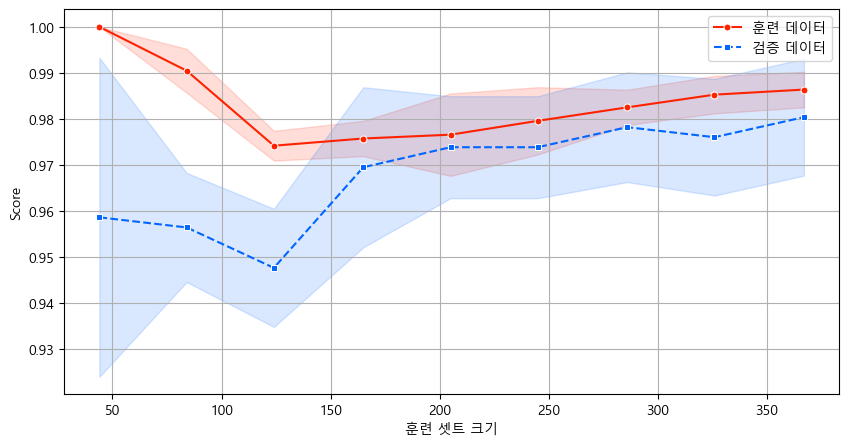

LogisticRegression(C=1, max_iter=500, n_jobs=-1)

In [21]:
my_logistic_classification(x_under, y_under, x_test, y_test, report=False)

> 정확도가 99% 까지 상승했다.
>
> 재현률이 97%로 증가했다.

#### (2) RandomOverSampler

In [22]:
oversampler = RandomOverSampler(sampling_strategy="minority", random_state=777)
x_over, y_over = oversampler.fit_resample(x_train, y_train)
y_over.value_counts()

0    254
1    254
Name: diagnosis, dtype: int64

[교차검증]
+----+-------+------------+-----------+-------------------+
|    |     C |   max_iter | penalty   |   mean_test_score |
|----+-------+------------+-----------+-------------------|
| 16 |   100 |        500 | l2        |          0.976412 |
|  7 |   0.1 |        500 | l2        |          0.972471 |
| 10 |     1 |        500 | l2        |          0.972471 |
| 13 |    10 |        500 | l2        |           0.96853 |
|  4 |  0.01 |        500 | l2        |           0.96655 |
|  1 | 0.001 |        500 | l2        |          0.909396 |
+----+-------+------------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.984338 |  

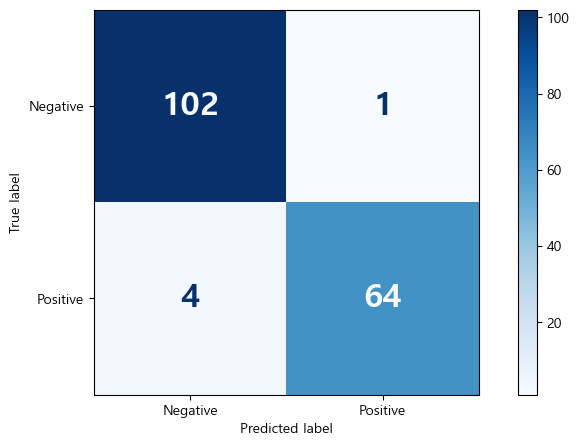


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


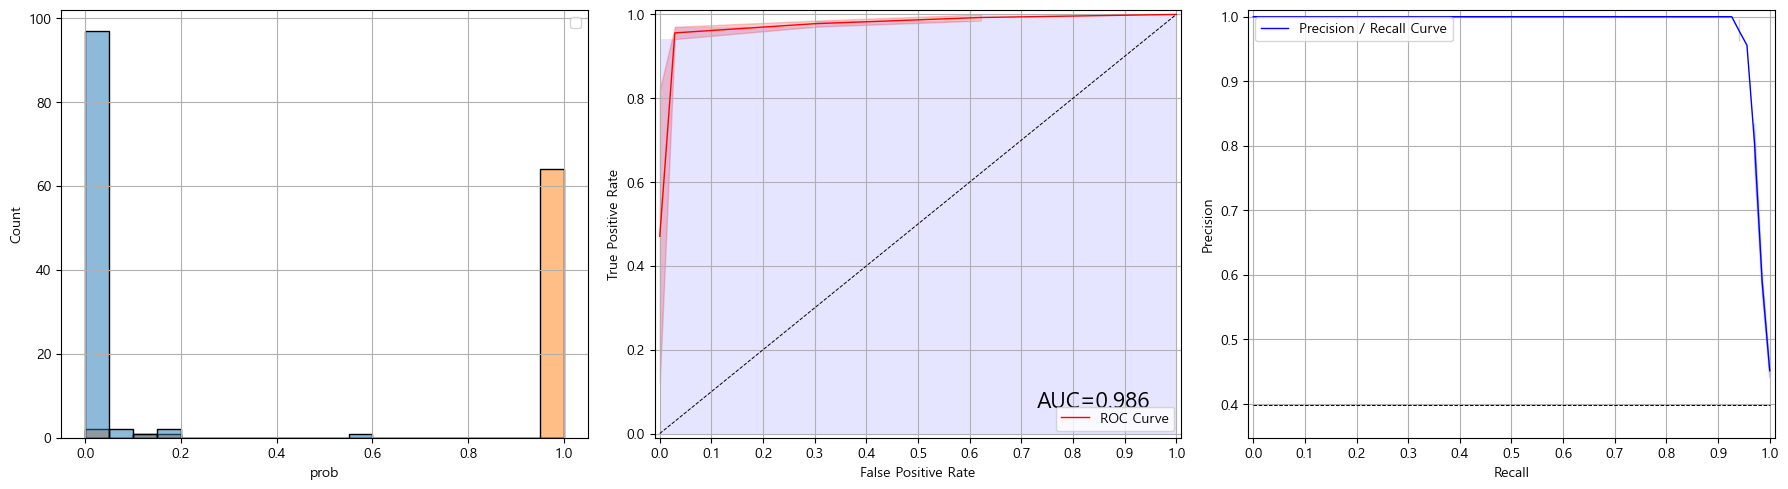


[학습곡선]


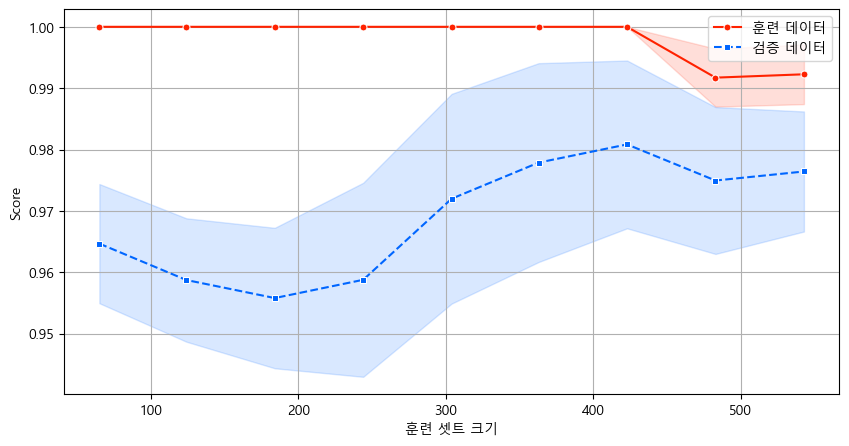

LogisticRegression(C=100, max_iter=500, n_jobs=-1)

In [23]:
my_logistic_classification(x_over, y_over, x_test, y_test, report=False)

> 정확도가 99% 까지 상승했다.
>
> 재현률이 97%까지 증가했다.

#### (3) SMOTE

In [24]:
smote_sampler = SMOTE(sampling_strategy="minority", k_neighbors=3, random_state=777)
x_sm, y_sm = smote_sampler.fit_resample(x_train, y_train)
y_sm.value_counts()

0    254
1    254
Name: diagnosis, dtype: int64

[교차검증]
+----+-------+------------+-----------+-------------------+
|    |     C |   max_iter | penalty   |   mean_test_score |
|----+-------+------------+-----------+-------------------|
| 13 |    10 |        500 | l2        |          0.974452 |
| 16 |   100 |        500 | l2        |           0.96855 |
|  7 |   0.1 |        500 | l2        |           0.96853 |
| 10 |     1 |        500 | l2        |           0.96655 |
|  4 |  0.01 |        500 | l2        |           0.96259 |
|  1 | 0.001 |        500 | l2        |          0.915356 |
+----+-------+------------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.963969 |  

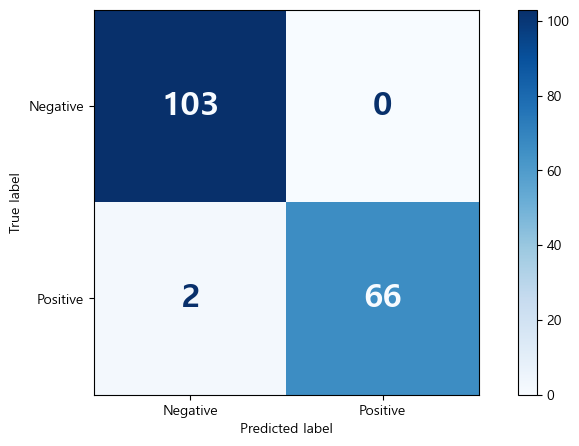


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


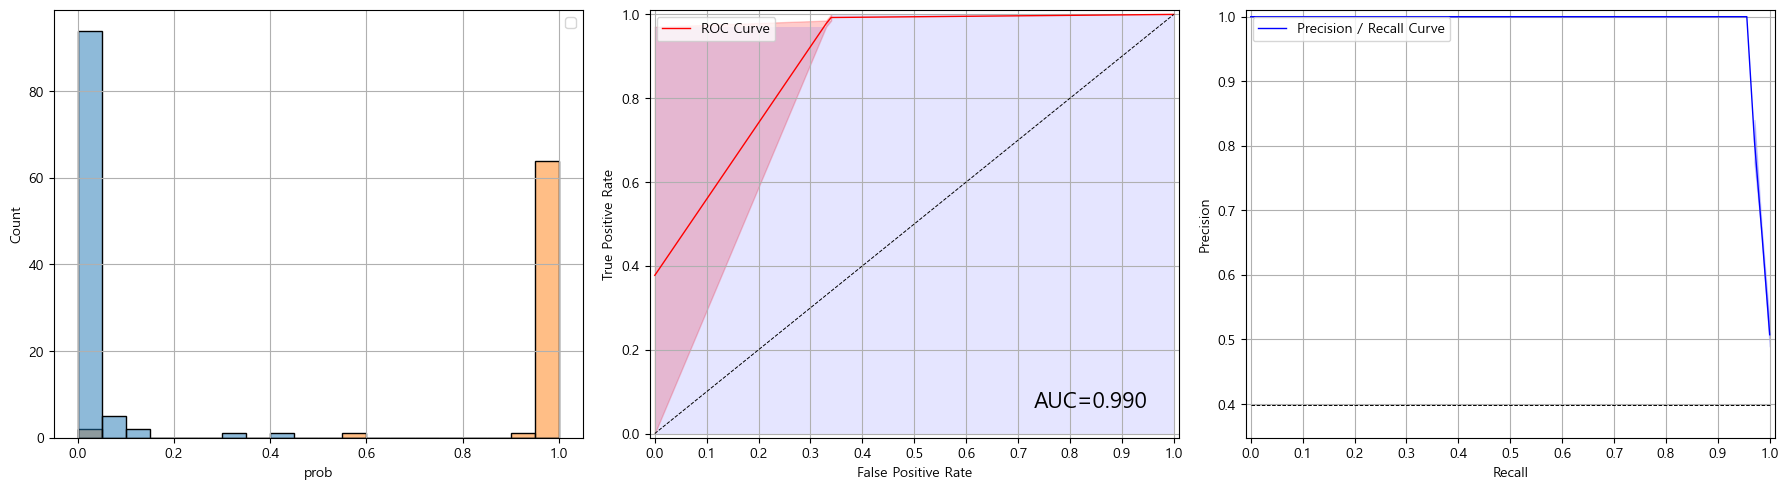


[학습곡선]


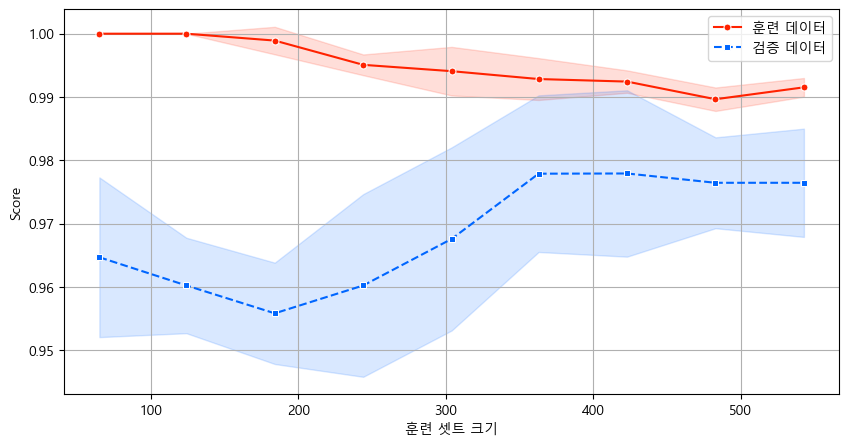

LogisticRegression(C=10, max_iter=500, n_jobs=-1)

In [25]:
my_logistic_classification(x_sm, y_sm, x_test, y_test, report=False)

> 정확도가 99% 까지 상승했다.
>
> 재현률이 97% 까지 증가했다.